### book

In [83]:
import sys
import pandas as pd
import numpy as np
import datetime as dt
import time
import math
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
import gdax, cbpro
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

class myWebsocketClient(cbpro.WebsocketClient):
    
    def on_open(self, prods = ["BTC-USD"]):
        self.url = "wss://ws-feed.pro.coinbase.com/"
        self.products = prods
        self.message_count = 0
        self.message_count2 = 0
        self.message_record =0
        self.exec=1
        self.channels = ['full']
        self.dfm = pd.DataFrame()

    def on_message(self, msg):
        self.message_count += 1
        if msg['type'] == 'match':
            self.message_count2 += 1
            #print(self.message_count, self.message_count2)
            self.dfm = pd.concat([self.dfm, pd.DataFrame([msg])[['time','price','size']]], axis=0)
            #self.dfm = pd.concat([self.dfm, pd.DataFrame([msg])], axis=0)
            
    def on_close(self):
        print("-- connection closed! --")
        
    def get_data(self):
        return self.dfm


def get_order_book3(x, agg=True, perc=2, round_position=0.01):
    
    typs = (('asks',True),('bids',False))
    df = pd.DataFrame()
    for typ in typs:
        df_ = pd.DataFrame(x[typ[0]])[[0,1]]
        df_[0] = df_[0].map(lambda x: float(x))
        df_[1] = df_[1].map(lambda x: float(x))
        #df_[0] = np.around(np.around(df_[0] / float(round_position)) * round_position, 2)
        
        if agg:
            df_ = df_.groupby(0).sum()
            df_ = df_.reset_index()
        df_.columns = [typ[0]+'_price', typ[0]+'_size']
        df_ = df_.sort_values(typ[0]+'_price', ascending=typ[1])
        df_ = df_.reset_index(drop=True)
        df = pd.concat([df,df_], axis=1)
        
    if perc > 0:
        #df = df[(-df.asks_price.isnull()) & (df.asks_price< df.iloc[0,0] * (1 + perc/100))]
        df = df[(-df.bids_price.isnull()) & (df.bids_price > df.iloc[0,2] * (1 - perc/100))]
        
    return df

def get_vwquotes(df, t, percs=[], tops=[]):
    
    df1 = pd.DataFrame([t], columns=['time'])
    if len(percs)>0:
        row1 = []
        for perc in percs:
            df_ = df[(-df.bids_price.isnull()) & (df.bids_price > df.iloc[0,2] * (1 - perc/100))]         
            df1['vwask_' + str(perc) + 'prc'] = (df_['asks_price'] * (df_['asks_size'] / df_['asks_size'].sum())).sum()
            df1['vwbid_' + str(perc) + 'prc'] = (df_['bids_price'] * (df_['bids_size'] / df_['bids_size'].sum())).sum()
            
    df2 = pd.DataFrame([t], columns=['time'])
    if len(tops)>0:  
        row2 = []
        for top in tops:
            df_ = df[(-df.bids_price.isnull())].head(top)
            df2['vwask_' + str(top) + 'top'] = (df_['asks_price'] * (df_['asks_size'] / df_['asks_size'].sum())).sum()
            df2['vwbid_' + str(top) + 'top'] = (df_['bids_price'] * (df_['bids_size'] / df_['bids_size'].sum())).sum()
            
    dfvw = pd.merge(df1, df2, on='time')
    
    return dfvw

def plot_pdf(data, label=''):
    from scipy.stats.kde import gaussian_kde
    from numpy import linspace
    #data = data[~np.isnan(data)]
    kde = gaussian_kde(list(data))
    dist_space = linspace(min(data), max(data), 100)
    plt.plot(dist_space, kde(dist_space), label=label)
    plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), shadow=True, ncol=1)
    plt.xticks(rotation=45)
    
def time_it(t1, text=''):
    t2 = time.time()

    if (t2 -t1 ) /3600 >1:
        print(text, 'time:', round((t2 -t1)/3600 ,4), 'hours')
    else:
        print(text, 'time:', round((t2 -t1)/60 ,4), 'minutes')

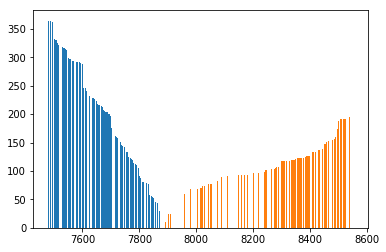

In [96]:
plt.rcParams["figure.figsize"] = (6,4)

public_client = gdax.PublicClient()
x = public_client.get_product_order_book('BTC-EUR', level=3)

dfag = get_order_book3(x, perc=5, round_position=0.01)

dfag['asks_size'] = dfag['asks_size'].cumsum()
dfag['bids_size'] = dfag['bids_size'].cumsum()

x_ = dfag['bids_price']
y_ = dfag['bids_size']
plt.bar(x_, y_)

x_ = dfag['asks_price']
y_ = dfag['asks_size']
plt.bar(x_, y_);

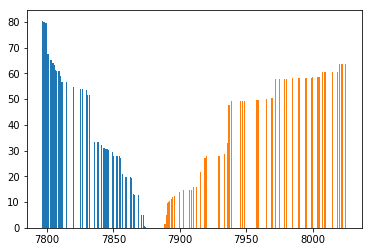

In [94]:
plt.rcParams["figure.figsize"] = (6,4)

public_client = gdax.PublicClient()
x = public_client.get_product_order_book('BTC-EUR', level=3)

dfag = get_order_book3(x, perc=1, round_position=1)

dfag['asks_size'] = dfag['asks_size'].cumsum()
dfag['bids_size'] = dfag['bids_size'].cumsum()

x_ = dfag['bids_price']
y_ = dfag['bids_size']
plt.bar(x_, y_)

x_ = dfag['asks_price']
y_ = dfag['asks_size']
plt.bar(x_, y_);

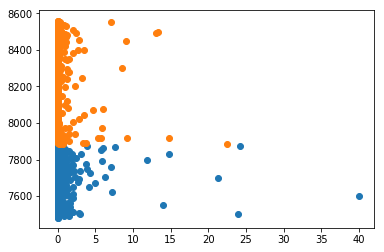

In [98]:
plt.rcParams["figure.figsize"] = (6,4)

public_client = gdax.PublicClient()
x = public_client.get_product_order_book('BTC-EUR', level=3)

dfag = get_order_book3(x, perc=5)

x_ = dfag['bids_size']
y_ = dfag['bids_price']
plt.scatter(x_, y_);

x_ = dfag['asks_size']
y_ = dfag['asks_price']
plt.scatter(x_, y_)

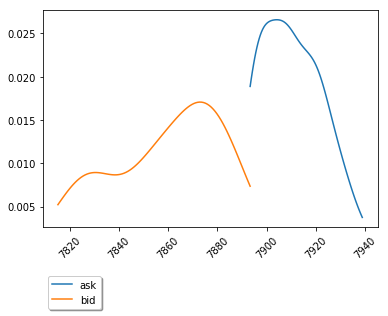

In [18]:
plot_pdf(dfag[(-dfag.asks_price.isnull())]['asks_price'], 'ask')
plot_pdf(dfag[(-dfag.bids_price.isnull())]['bids_price'], 'bid');

In [253]:
dfag

,asks_price,asks_size,bids_price,bids_size
0,7963.95,0.290614,7963.00,0.098363
1,7963.99,2.000000,7955.01,0.800000
2,7964.00,6.501507,7955.00,0.003817
3,7965.00,0.100000,7954.95,0.181631
4,7965.80,0.569000,7954.54,0.861481
5,7966.32,0.393000,7954.00,0.020489
6,7967.00,0.100000,7953.00,0.020000
7,7967.04,0.721714,7950.12,0.288679
8,7971.52,0.100000,7950.00,0.273683
9,7975.18,5.999000,7948.43,0.721714


In [274]:
##run together pricing and order book - no threading

iterrations = 3

public_client = gdax.PublicClient()
wsClient = myWebsocketClient(["BTC-USD"])
wsClient.start()

dfb = pd.DataFrame()
t1x = time.time()
for sec in range(iterrations):
        
    if not (sec) % 100:
        print(sec, dt.datetime.now())

    dft = pd.DataFrame([public_client.get_time()])
    t = dft.iloc[0,1]
    t = dt.datetime(int(t[:4]), int(t[5:7]), int(t[8:10]), int(t[11:13]), int(t[14:16]), int(t[17:19]))
    
    dft = pd.DataFrame([public_client.get_time()])
    x = public_client.get_product_order_book('BTC-USD', level=3)
    df = get_order_book3(x, True, 0.03)
    dfb = pd.concat([dfb, get_vwquotes(df, t, percs=[1,2,3], tops=[1,5,10])], axis=0)
    #time.sleep(1)
    
time_it(t1x, 'download time')
    
wsClient.close()
dfp = wsClient.get_data()

##preprocessing dfb and dfp
dfp.iloc[:,1:] = dfp.iloc[:,1:].apply(pd.to_numeric, downcast='float')
dfp['time'] = dfp['time'].map(lambda x: dt.datetime(int(x[:4]), int(x[5:7]), int(x[8:10]), int(x[11:13]), int(x[14:16]), int(x[17:19])))
dfb = dfb.reset_index(drop=True)
dfb = dfb.drop_duplicates(subset='time', keep='last') #not too nice
dfp = dfp.reset_index(drop=True)

#get vwprice for each second
dfp['price'] = dfp['price'] * (dfp['size'] / dfp[['time','price','size']].groupby('time').transform(sum)['size'])
dfp = dfp[['time','price','size']].groupby('time').sum().reset_index()
dfp['price'] = dfp['price'].round(2) #round to 2 decimal places

#mapping order book and websocket prices on closest book time
def book_time(ptime):
    '''get the order book timestamp that is closest to the price timestamp to map both'''
    tdeltas = ptime - dfb.time[ptime >= dfb.time]
    idxmin = tdeltas[tdeltas==tdeltas.min()].index
    try:
        return list(dfb.time[idxmin])[0]
    except:
        return np.nan
    
dfp['maptime'] = dfp['time'].map(book_time)

dfh = pd.merge(dfp, dfb, how='left', left_on=['maptime'], right_on=['time'], suffixes=['','book'])
del dfh['maptime']

#dfh.to_pickle(r'C:\Users\ROB4473\OneDrive - Robeco Nederland B.V\learn\New folder\h.pck1.gz', compression='gzip')

0 2019-11-08 16:56:37.045399
download time time: 0.052 minutes
-- connection closed! --


In [210]:
dfh = pd.read_pickle(r'C:\Users\ROB4473\OneDrive - Robeco Nederland B.V\learn\New folder\h.pck1.gz', compression='gzip') #1h
#dfh = pd.read_pickle(r'C:\Users\ROB4473\OneDrive - Robeco Nederland B.V\learn\New folder\h.pck.gz', compression='gzip') #36min
print(len(dfh), 'records in', (dfh.iloc[len(dfh)-1,0] - dfh.iloc[0,0]))
dfh.head(2)

1183 records in 0 days 01:02:52


,time,price,size,timebook,vwask_1prc,vwbid_1prc,vwask_2prc,vwbid_2prc,vwask_3prc,vwbid_3prc,vwask_1top,vwbid_1top,vwask_5top,vwbid_5top,vwask_10top,vwbid_10top
0,2019-11-07 12:56:36,9172.82,0.010431,2019-11-07 12:56:36,9173.796281,9172.594214,9173.796281,9172.594214,9173.796281,9172.594214,9172.82,9172.81,9173.787786,9172.798498,9173.796281,9172.594214
1,2019-11-07 12:56:37,9172.82,1.642781,2019-11-07 12:56:37,9173.730177,9172.594234,9173.730177,9172.594234,9173.730177,9172.594234,9172.82,9172.81,9173.721305,9172.798499,9173.730177,9172.594234


In [211]:
## add more X variables

# order book vwap returns for 5 and 10 periods
retcols = dfh.columns[5:]
for per in [5,10]:
    ret = np.array(dfh[retcols].iloc[per:len(dfh), :]) / np.array(dfh[retcols].iloc[:len(dfh)-per, :]) - 1
    dfret = pd.DataFrame(ret, columns = retcols + '_ret_' + str(per) + 'p', index=dfh.index[per:])
    dfh = pd.concat([dfh, dfret], axis=1)

#for reference: https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
dfh['price_SMA_5'] = dfh.loc[:,'price'].rolling(window=5).mean()
dfh['price_EMA_5'] = dfh.loc[:,'price'].ewm(span=5, adjust=False).mean()

## y variables
dfh = pd.concat([dfh, pd.DataFrame(np.array(dfh.loc[1:,'price']), columns=['y1'])],axis=1) #close in 1 period
dfh = pd.concat([dfh, pd.DataFrame(np.array(dfh.loc[5:,'price']), columns=['y5'])],axis=1) #close in 5 periods

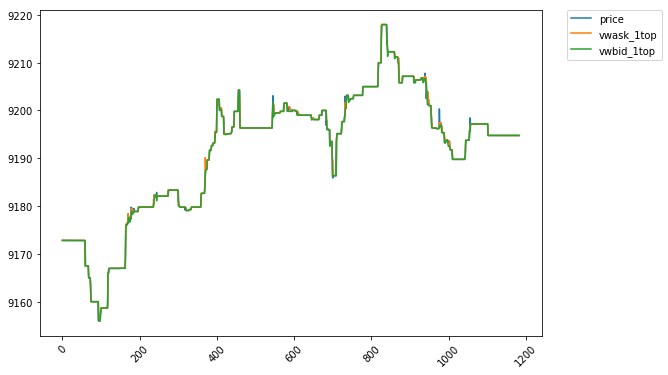

In [212]:
plt.rcParams["figure.figsize"] = (9,6)
dfh.loc[:,['price','vwask_1top','vwbid_1top']].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45);

In [242]:
##reg1 = LASSO

ew = 100 #estimation window
normalize=True
predicted_period = 5 #of y variable

y = 'y' + str(predicted_period)

dfpred = pd.DataFrame()
for i in range(len(dfh) - ew + 1 - predicted_period):
    
    dfe = dfh.iloc[i:i + ew, :]   
    dfe = dfe.dropna(axis=0)
    x_var = dfe.iloc[:,4:-2] # depends on he position of the vars
    y_var = dfe[y]
    
    x_varpred = dfh.iloc[[i + ew], 4:-2] #predict on the next period variables
    
    reg1 = LassoCV(cv=10, precompute=True, fit_intercept=True, n_alphas=15, normalize=normalize).fit(x_var, y_var)    
    pred1 = np.dot(reg1.coef_, np.array(x_varpred).T) + reg1.intercept_
   
    dfpred = pd.concat([dfpred, pd.DataFrame([dfh.iloc[i + ew, 0], pred1[0]]).T]) #mapped result to prediction time (next period)

dfpred.reset_index(drop=True, inplace=True)
dfpred.columns = ['time','ypred1']
dfh['time'] = dfh['time'].map(str)
dfpred['time'] = dfpred['time'].map(str)
dfres1 = pd.merge(dfh[['time','price', y]], dfpred, how='left', on='time')
dfres1 = dfres1[-dfres1.ypred1.isnull()][['time','price', y, 'ypred1']]

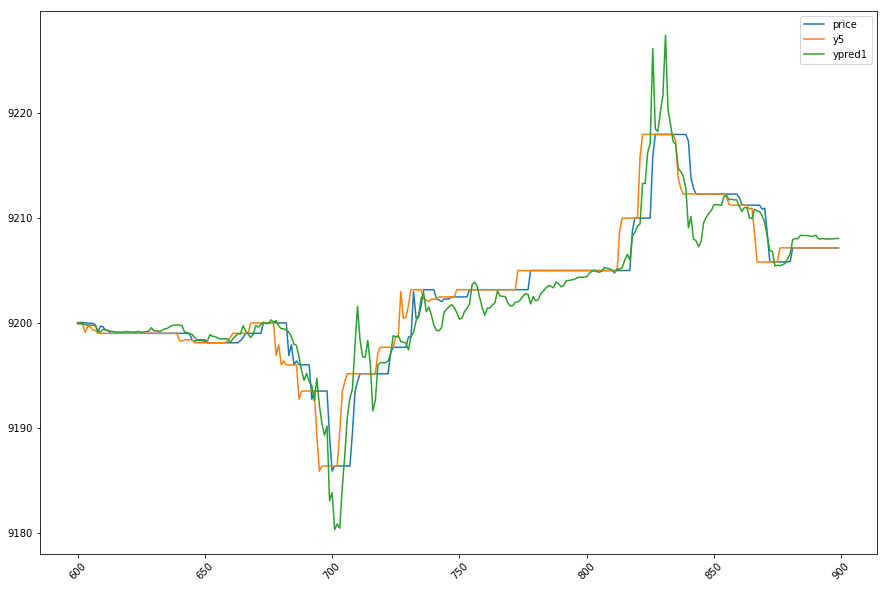

In [247]:
plt.rcParams["figure.figsize"] = (15,10)
dfres1.iloc[500:800,:][['price', y, 'ypred1']].plot()
plt.xticks(rotation=45);

In [179]:
#which factors influenced the most (last itereation)?
i=0
for c in reg2.coef_:
    if c>0:
        print(i, c)
    i+=1

1 0.04426027639934572
2 0.1936341896651736
3 0.027072615010483775
5 4.726566011765903e-15
7 0.14854127096691516
8 0.009334111438879761
9 0.5156031246576067
19 122.39567920847934
20 21.72846281363729


In [181]:
x_varpred.iloc[:,[1,2,3,5,7,8,9,19,20]]

,vwbid_1prc,vwask_2prc,vwbid_2prc,vwbid_3prc,vwbid_1top,vwask_5top,vwbid_5top,vwask_5top_ret_5p,vwbid_5top_ret_5p
1178,9194.108984,9194.86343,9194.108984,9194.108984,9194.77,9194.86343,9194.108984,-0.000045,0.000024
